In [148]:
import pandas as pd
import numpy as np
from scipy import stats
import sys
import matplotlib.pyplot as plt
from dateutil.parser import parse
import parse as str_parse
from new_proximity.intersection_proximity import compute_proximity
from importlib import reload
from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
from sklearn.linear_model import SGDRegressor
import seaborn as sns

users = pd.read_csv('ml-users.csv') 
%matplotlib notebook

In [149]:
crop_rows = -1

In [150]:
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip')

if crop_rows > 0:
    df_interactions = df_interactions.head(crop_rows)

isna_result = pd.isna(df_interactions['action'])
df_interactions= df_interactions[~isna_result]
isna_result = pd.isna(df_interactions['action'])
assert sum(df_interactions['action'].isna()) == 0

df_interactions.rename(columns = {'ml-interactions.csv':'timestamp'}, inplace = True)

In [151]:
point_labels = pd.read_csv('sidewalk-seattle-label_point.csv')
point_labels.set_index('label_id', inplace=True)

In [152]:
label_correctness = pd.read_csv('ml-label-correctness.csv')

In [153]:
labeling_cols = ['user_id', 'audit_task_id', 'temporary_label_id']

In [154]:
label_correctness.drop(columns='label_type', inplace=True)

In [155]:
label_correctness.set_index(labeling_cols, inplace=True)

In [156]:
# TODO: figure out why there are duplicates
label_correctness = label_correctness[~label_correctness.index.duplicated()]

In [157]:
label_correctness = label_correctness[~label_correctness['correct'].isna()]

In [158]:
df_interactions.set_index(labeling_cols, inplace=True)

In [159]:
df_interactions.reset_index(inplace=True)

In [160]:
# # fill nan temporary label id's
# df_interactions['temporary_label_id'] = df_interactions['temporary_label_id'].fillna(method='bfill')

# # get rid of nan label id's
# df_interactions = df_interactions[~pd.isna(df_interactions['temporary_label_id'])]

In [161]:
labels = df_interactions[df_interactions['action'] == 'LabelingCanvas_FinishLabeling']

In [162]:
labels.reset_index(inplace=True)

In [163]:
labels['audit_task_id'] = labels['audit_task_id'].astype(int)

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [164]:
labels['temporary_label_id'] = labels['temporary_label_id'].astype(int)

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [165]:
labels.set_index(labeling_cols, inplace=True)

In [166]:
labels_joined = label_correctness.join(labels, how='inner')

In [167]:
labels_joined.drop(['action', 'audit_task_interaction_id', 'timestamp', 'mission_id', 'lat', 'lng'], axis=1, inplace=True)

In [168]:
def parse_note(x):
    result = str_parse.parse('labelType:{},canvasX:{},canvasY:{}', x)
    return pd.Series({
        'labelType': result[0],
        'canvasX': result[1],
        'canvasY': result[2]
    })
    
labels_joined = labels_joined.join(labels_joined['note'].apply(parse_note))

In [169]:
no_sidewalk_labels = labels[labels['note'].apply(parse_note)['labelType'] == 'NoSidewalk'][['lat', 'lng']]

In [170]:
labels_joined.drop('note', inplace=True, axis=1)

In [171]:
labels_joined['correct'] = labels_joined['correct'] == 't'

In [172]:
labels_joined.reset_index(inplace=True)

In [173]:
labels_joined.set_index('label_id', inplace=True)

In [ ]:
labels_joined = labels_joined.join(point_labels[['sv_image_x', 'sv_image_y', 'lat', 'lng']], how='inner')

In [440]:
# curb_ramp = labels_joined[labels_joined['labelType'] == 'CurbRamp']

In [441]:
# X = curb_ramp[['canvasX', 'canvasY', 'pitch']].values

In [442]:
# y = curb_ramp['correct'].values

In [443]:
# X = X.astype(int)

In [448]:
# plt.figure()
# plt.scatter(X[:, 1], X[:, 2], c=y)

In [445]:
# clf = SGDRegressor()

In [446]:
# clf.fit(X, y)

In [447]:
# y_pred = clf.predict(X)

In [449]:
# plt.figure()
# plt.scatter(X[:, 1], X[:, 2], c=y_pred)

In [450]:
# fig, ax = plt.subplots()
# ax = plt.axes(projection='3d')

# xline = X[:, 0]
# yline = X[:, 1]
# zline = X[:, 2]

# ax.set_xlabel('Dimension 0')
# ax.set_ylabel('Dimension 1')
# ax.set_zlabel('Dimension 2')
# ax.scatter3D(xline, yline, zline, c=y_pred)

In [41]:
def dist_prox(row):
    try:
        ip = compute_proximity(row.lat, row.lng)
        return pd.Series({
            'distance': ip[0],
            'percent': ip[1]
        })
    except Exception:
        return pd.Series({
            'distance': -1,
            'percent': -1
        })

In [49]:
labels_joined = labels_joined.join(labels_joined.apply(dist_prox, axis=1))

In [60]:
print(compute_proximity(47.670784, -122.398476))

(63.88030974158521, 93.08618039582596)


<IPython.core.display.Javascript object>


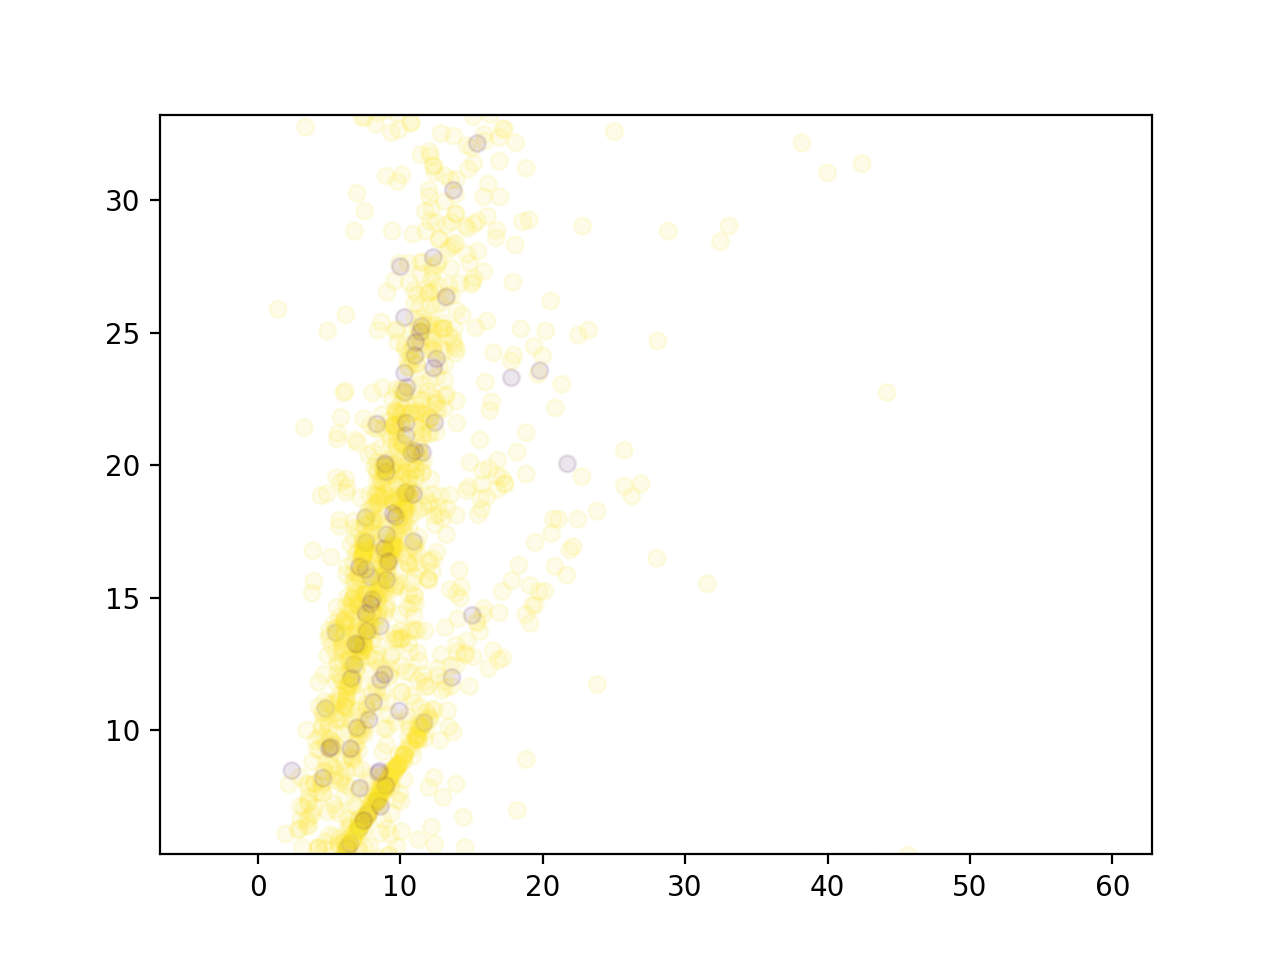

In [55]:
selection = labels_joined[labels_joined.labelType == 'CurbRamp']
plt.figure()
plt.scatter(selection.distance, selection.percent, c=selection['correct'], alpha=0.1)

In [132]:
no_sidewalk_labels = no_sidewalk_labels[no_sidewalk_labels.lat > 46]

<IPython.core.display.Javascript object>


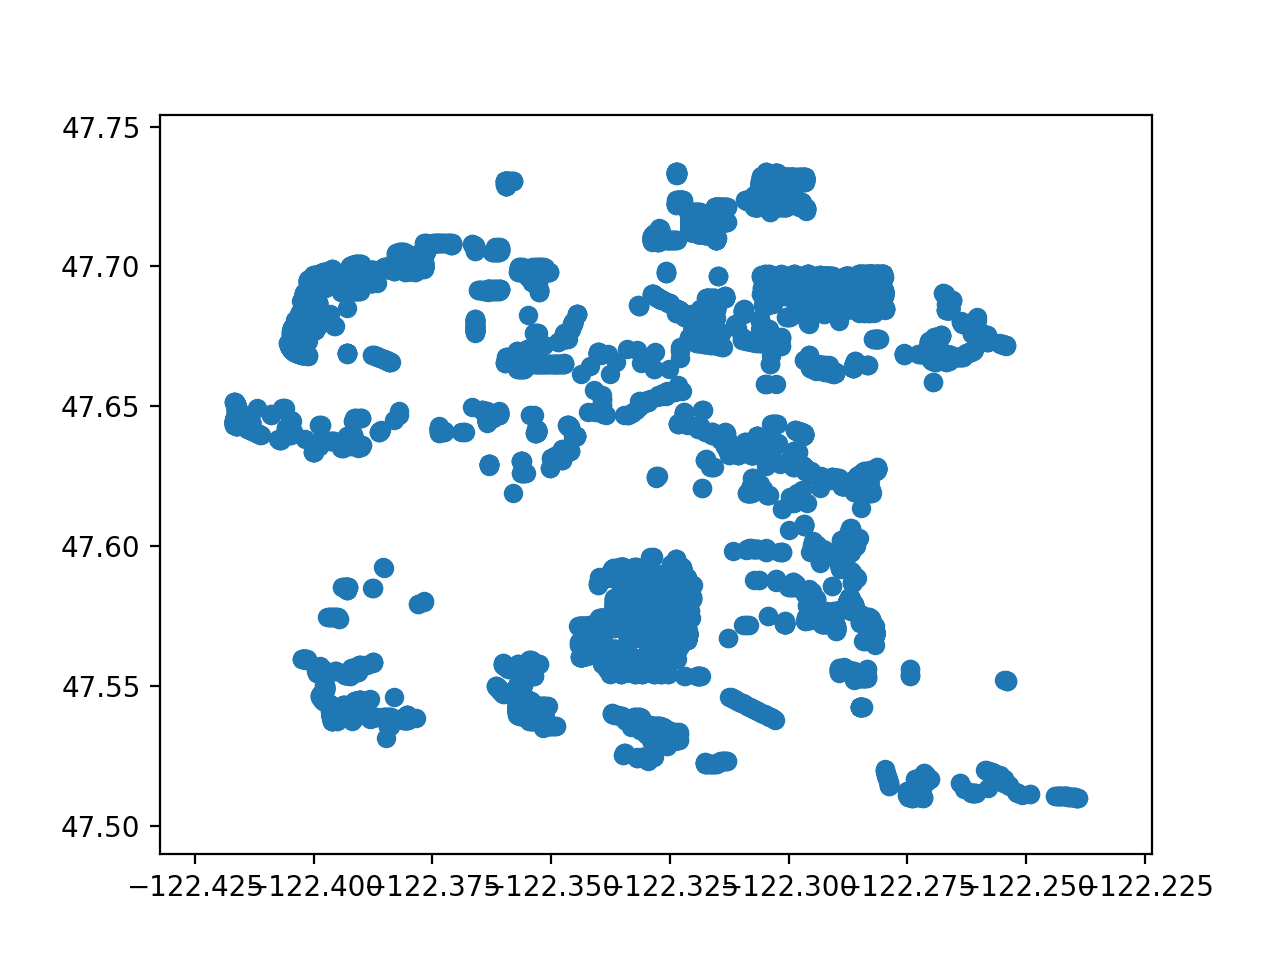

In [133]:
plt.figure()
plt.scatter(no_sidewalk_labels.lng, no_sidewalk_labels.lat)

In [32]:
# def dist_to_street(row):
#     try:
#         return pd.Series({
#             'dist_to_street': intersection_proximity.compute_dist_to_street(row.lat, row.lng)
#         })
#     except Exception:
#         return pd.Series({
#             'dist_to_street': -1
#         })

In [33]:
# labels_joined = labels_joined.join(labels_joined.apply(dist_to_street, axis=1))

In [30]:
le = preprocessing.LabelEncoder()
# transform label_type into an int
labels_joined['label_type'] = le.fit_transform(labels_joined['labelType'])

In [32]:
# # OR one-hot encoding
# oh = preprocessing.OneHotEncoder(handle_unknown='ignore')
# one_hot_label = oh.fit_transform(labels_joined['labelType'].values.reshape(-1, 1)).todense()

In [31]:
# # fetch census tract data
# # takes about 0.8s per request

# import requests                                                                                                                                                                                             
# import json                                                                                                                                                                                                 

# def fetch_census_data(lng, lat):                                                                                                                                                                            
#     geocode_url = 'https://geomap.ffiec.gov/FFIECGeocMap/GeocodeMap1.aspx/GetGeocodeData'                                                                                                                   
#     census_url = 'https://geomap.ffiec.gov/FFIECGeocMap/GeocodeMap1.aspx/GetCensusData'                                                                                                                     
#     data = {'sSingleLine': '-122.34080895597496, 47.608319043773058', 'iCensusYear': '2017'}                                                                                                                
#     headers = {'Accept': 'application/json, text/javascript, */*; q=0.01', 'Content-Type': 'application/json; charset=utf-8'}                                                                               
#     r = requests.post(geocode_url, data=json.dumps(data), headers=headers)                                                                                                                                  
#     j = json.loads(r.content)                                                                                                                                                                               
#     r2 = requests.post(census_url, data=json.dumps({'sMSACode': j['d']['sMSACode'], 'sStateCode': j['d']['sStateCode'], 'sCountyCode': j['d']['sCountyCode'], 'sTractCode': j['d']['sTractCode'], 'iCensusYear': j['d']['iCensusYear']}), headers=headers)                                                                                                                                                                                                 
#     j2 = json.loads(r2.content)                                                                                                                                                                              
#     return pd.Series(j2['d'])  


In [32]:
# %%time
# census_tract_data = labels_joined.apply(lambda x: fetch_census_data(x['lng'], x['lat']), axis=1)

In [33]:
labels_joined.head()

,user_id,audit_task_id,temporary_label_id,correct,index,gsv_panorama_id,heading,pitch,zoom,labelType,canvasX,canvasY,sv_image_x,sv_image_y,lat,lng,distance,percent,dist_to_street,label_type
label_id,,,,,,,,,,,,,,,,,,,,
10407,0e1ae564-6d72-4670-98e4-71369cc5ab26,3366,5,True,18364631,L7SZej2SoaWbaqWE5bdB3Q,163.000000,-35.0000,1.0,NoCurbRamp,642,226,7629,-934,47.673359,-122.401878,10.140893,12.776624,4.897178,1
10409,0e1ae564-6d72-4670-98e4-71369cc5ab26,3367,7,False,18368154,KR-t1fL7CYXLuiwOpovEow,246.437500,-29.5625,1.0,NoCurbRamp,490,294,10007,-1294,47.672207,-122.401894,7.524051,22.726504,4.664472,1
10412,0e1ae564-6d72-4670-98e4-71369cc5ab26,3368,3,True,18372571,FDr1tDKldYX_PRQYQG713A,282.375000,-28.2500,1.0,SurfaceProblem,484,167,11160,-580,47.678715,-122.398766,31.683946,47.728451,1.872057,3
10413,0e1ae564-6d72-4670-98e4-71369cc5ab26,3368,4,False,18372984,EfYgFxuE0WkXVYEo0DJRsg,282.187500,-29.9375,1.0,SurfaceProblem,490,147,11177,-508,47.678722,-122.398911,43.905207,66.138486,2.937464,3
10429,0e1ae564-6d72-4670-98e4-71369cc5ab26,3378,20,True,18386753,-8GxPT6Z3OKYFimrUcYi1A,39.032169,-35.0000,1.0,CurbRamp,426,206,1897,-1076,47.687786,-122.402542,1.137692,15.489896,8.363878,0


In [139]:
np.unique(labels_joined['labelType'])

array(['CurbRamp', 'NoCurbRamp', 'Obstacle', 'SurfaceProblem'],
      dtype=object)

<IPython.core.display.Javascript object>


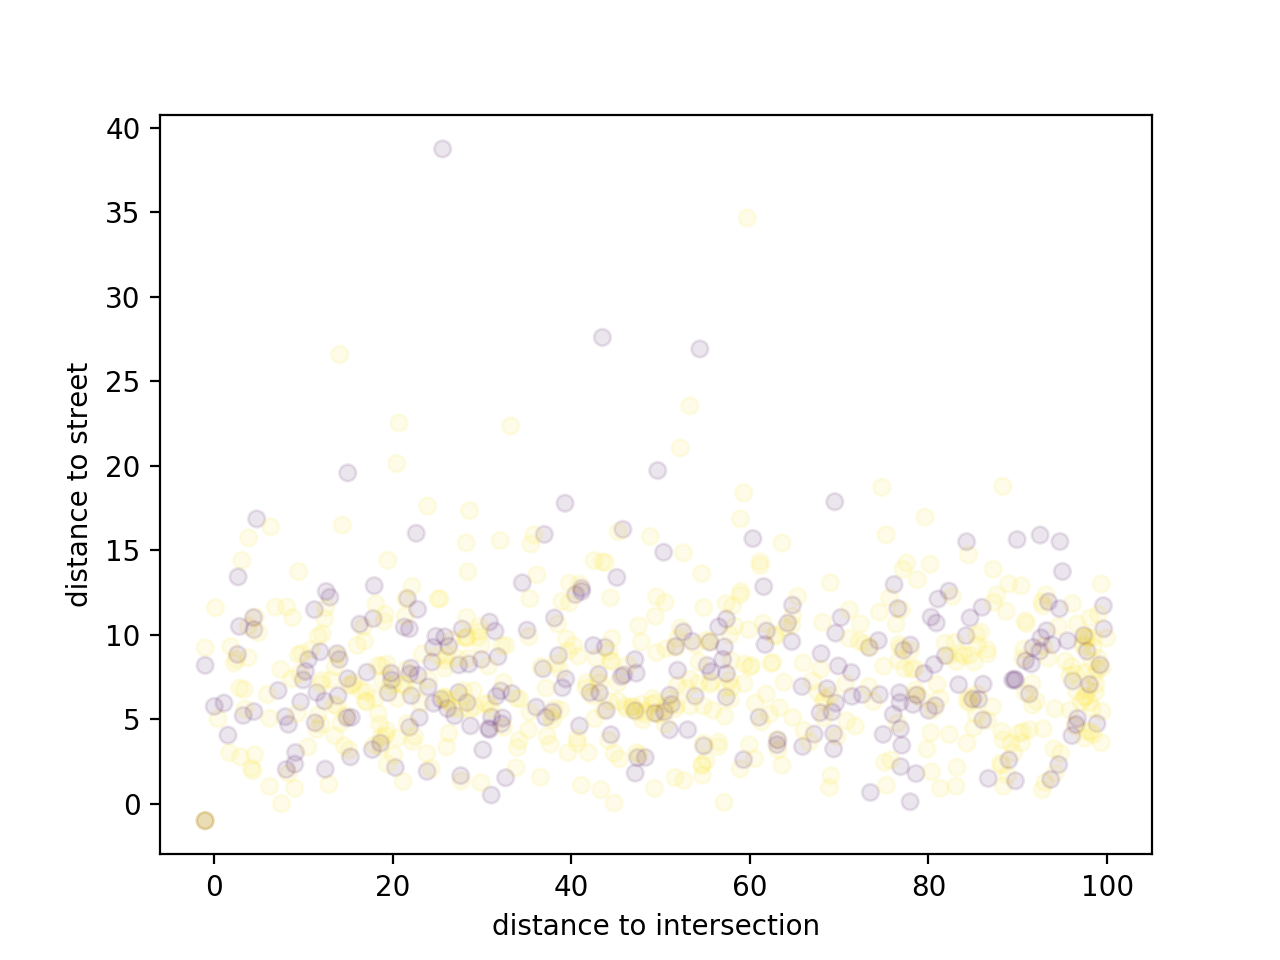

In [145]:
selection = labels_joined[labels_joined['labelType'] == 'Obstacle']
plt.figure()
plt.xlabel('distance to intersection')
plt.ylabel('distance to street')
plt.scatter(selection['percent'], selection['dist_to_street'], c=selection['correct'], alpha=0.1)

In [277]:
selection = labels_joined[labels_joined['distance'] > 0]
selection = selection.iloc[(np.random.choice(selection.shape[0], 100))]
selection = selection[['lat', 'lng', 'distance', 'percent']]
# plt.figure()
# plt.xlabel('distance to intersection (m)')
# plt.ylabel('middleness (%)')
# plt.scatter(selection['distance'], selection['percent'], alpha=0.1)

In [290]:
def _debug_proximity(x):
#     print(x)
    t = intersection_proximity.compute_proximity(x.lat, x.lng)
    return pd.Series({
        'start_lng': t[0][0],
        'start_lat': t[0][1],
        'end_lng': t[1][0],
        'end_lat': t[1][1]
    })

In [291]:
a = selection.apply(lambda x: _debug_proximity(x), axis=1)

In [304]:
selection = selection.join(a)

In [306]:
selection.to_csv('selection.csv')

In [329]:
selection.loc[64770]

lat           47.719975
lng         -122.296417
distance       1.849532
percent       72.935507
start_lng   -122.296321
start_lat     47.720000
end_lng     -122.296321
end_lat       47.719959
Name: 64770, dtype: float64

In [248]:
a = labels_joined[(labels_joined['percent'] > 90) & (labels_joined['labelType'] == 'CurbRamp')].iloc[0]

In [249]:
labels_joined[(labels_joined['percent'] > 80) & (labels_joined['distance'] < 10)].head()

,user_id,audit_task_id,temporary_label_id,correct,index,gsv_panorama_id,heading,pitch,zoom,labelType,canvasX,canvasY,sv_image_x,sv_image_y,lat,lng,distance,percent,dist_to_street,label_type
label_id,,,,,,,,,,,,,,,,,,,,
11899,0e1ae564-6d72-4670-98e4-71369cc5ab26,3668,78,True,202741,ezXBg8ahZ2494jUVlGSpgw,297.223206,-13.598214,2.0,SurfaceProblem,246,179,10666,-298,47.683037,-122.398453,7.241458,98.047925,8.356228,3
20894,0e1ae564-6d72-4670-98e4-71369cc5ab26,5720,104,True,2614690,1daEQJnoMRlZnAahCLMeyw,348.267853,-18.750000,2.0,NoCurbRamp,350,169,12856,-457,47.683220,-122.398392,1.631720,91.602598,7.595628,1
22474,0e1ae564-6d72-4670-98e4-71369cc5ab26,6064,415,True,3224615,C30JRxxPfv-6_56OTQ4RJg,20.196428,0.000000,1.0,SurfaceProblem,585,324,1937,-412,47.674923,-122.406212,5.545580,89.173910,10.572796,3
28382,0e1ae564-6d72-4670-98e4-71369cc5ab26,7227,108,False,4899130,A-eM226LYCgGNB1WLubj8Q,198.082596,-7.506696,3.0,CurbRamp,386,235,7378,-251,38.940800,-77.067863,9.874815,81.898430,7.325917,0
28419,0e1ae564-6d72-4670-98e4-71369cc5ab26,7234,3,True,4916364,Utvu8N-BeLGgLsZ8TmLsDA,343.312500,-15.062500,1.0,CurbRamp,561,267,514,-620,47.622826,-122.297302,4.792237,81.917108,5.244383,0


In [460]:
labels_joined.shape

(5406, 20)

# Classification

In [177]:
features = ['pitch', 'label_type', 'canvasX', 'canvasY', 'distance', 'percent', 'dist_to_street', 'sv_image_x', 'sv_image_y']

In [439]:
# X = labels_joined[['pitch', 'label_type', 'canvasX', 'canvasY', 'distance', 'percent']].values
X = labels_joined[features].values
y = labels_joined['correct'].astype(int).values
label_id = labels_joined.index.values
label_type = labels_joined['labelType'].values

In [345]:
# # only select a certain type
# mask = (label_type=='NoCurbRamp')
# X = X[mask]
# y = y[mask]
# label_id = label_id[mask]
# label_type = label_type[mask]

In [346]:
# X = np.concatenate((X, one_hot_label), axis=1)

In [347]:
# # Undersample the majority class
# incorrect_indices, = np.where(y == 0)
# correct_indices, = np.where(y == 1)
# needed = min(len(incorrect_indices), len(correct_indices))
# chosen_indices = np.concatenate((np.random.choice(correct_indices, needed, replace=False), np.random.choice(incorrect_indices, needed, replace=False)))

# X = X[chosen_indices]
# y = y[chosen_indices]

In [348]:
# label_type = label_type[chosen_indices]

In [43]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegressionCV
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

Using TensorFlow backend.


In [441]:
cutoff_invalid = 0.8
cutoff_valid = 0.8

In [ ]:
total = 0
predicted = 0
tp = 0
tn = 0
fp = 0
fn = 0
counter = 0
correct_prob = np.zeros(y.shape[0])
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(X):
    counter += 1

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
#     sampler = RandomUnderSampler(random_state=0)
#     sampler = RandomOverSampler(random_state=0)
#     X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    X_resampled, y_resampled = X_train, y_train 
#     X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    
    clf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=1000)
#     clf = BalancedRandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=1000)
#     clf = BaggingClassifier(random_state=0)
#     clf = LogisticRegressionCV(n_jobs=-1, random_state=0, cv=5, max_iter=500)
#     clf = DecisionTreeClassifier(random_state=0)
#     clf = MLPClassifier(random_state=0, verbose=True)
    clf.fit(X_resampled, y_resampled)
    
#     neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    
#     with open("tree.txt", "w") as f:
#         f = export_graphviz(clf, out_file=f)
    use_probabilities = False
    
    if use_probabilities:
        prediction = clf.predict_proba(X_test)
    else:
        p = clf.predict(X_test)
        prediction = np.concatenate([1-p, p]).reshape((y_test.shape[0], 2))
        
    correct_prob[test_index] = prediction[:, 1]
    pred_neg = prediction[:, 0] > cutoff_invalid
    pred_pos = prediction[:, 1] > cutoff_valid

    tn_ = np.sum(y_test[pred_neg] == 0)
    fn_ = np.sum(pred_neg) - tn_
    tp_ = np.sum(y_test[pred_pos] == 1)
    fp_ = np.sum(pred_pos) - tp_


#     print('tn: ' + str(label_id[test_index][pred_neg & (y_test == 0)]))
#     print('fn: ' + str(label_id[test_index][pred_neg & (y_test == 1)]))
    
    print(f'tn: {tn_}, tp: {tp_}, fn: {fn_}, fp: {fp_}')
    
    predicted += (tn_ + fn_ + tp_ + fp_)
    tn += tn_
    fn += fn_
    tp += tp_
    fp += fp_
    
    total += y_test.shape[0]

In [443]:
# plt.figure()
# plt.ylabel('importance')
# plt.title('Feature Importances')
# plt.bar(features, clf.feature_importances_)
# locs, labels = plt.xticks()
# _ = plt.setp(labels, rotation=45)

In [444]:
accuracy = (tp + tn) / predicted
print(f'precision:\t{100*accuracy:.2f}%')
print(f'recall:\t\t{100*tn/(tn+fp):.2f}%')
print(f'predicted:\t{100*predicted/total:.2f}%')
print(f'tp / tp + fp:\t{100*tp/(tp+fp):.2f}%')
print(f'tn / tn + fn:\t{100*tn/(tn+fn):.2f}%')

precision:	50.22%
recall:		49.69%
predicted:	100.00%
tp / tp + fp:	81.84%
tn / tn + fn:	18.18%


0.5022197558268591

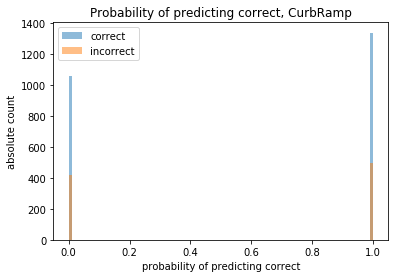

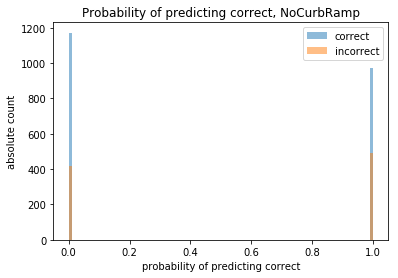

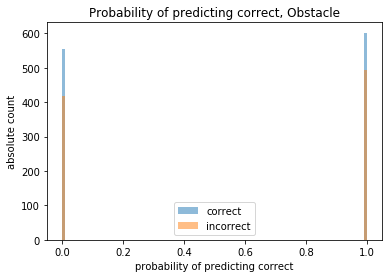

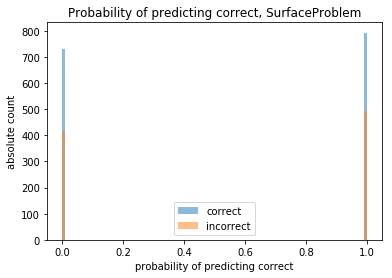

In [187]:
for chosen_type in np.unique(label_type):
    fig = plt.figure()
    plt.title(f'Probability of predicting correct, {chosen_type}')
    plt.hist(correct_prob[y==1 & (label_type == chosen_type)], bins=100, alpha=0.5, label='correct')
    plt.hist(correct_prob[y==0 & (label_type == chosen_type)], bins=100, alpha=0.5, label='incorrect')
    plt.xlabel('probability of predicting correct')
    plt.ylabel('absolute count')
    plt.legend()

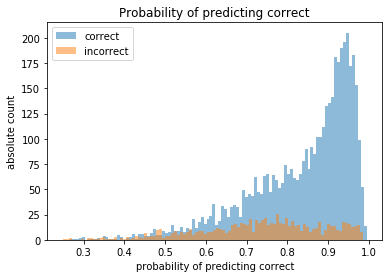

In [164]:
fig = plt.figure()
plt.title(f'Probability of predicting correct')
plt.hist(correct_prob[y==1], bins=100, alpha=0.5, label='correct')
plt.hist(correct_prob[y==0], bins=100, alpha=0.5, label='incorrect')
plt.xlabel('probability of predicting correct')
plt.ylabel('absolute count')
plt.legend()

## Classifying correctness based on lat/lng

In [178]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics

In [179]:
vals = pd.DataFrame([labels_joined['lat'], labels_joined['lng'], labels_joined['correct']]).T

In [180]:
vals = vals[(vals['lat'] > 47) & (vals['lat'] < 48)]

<IPython.core.display.Javascript object>


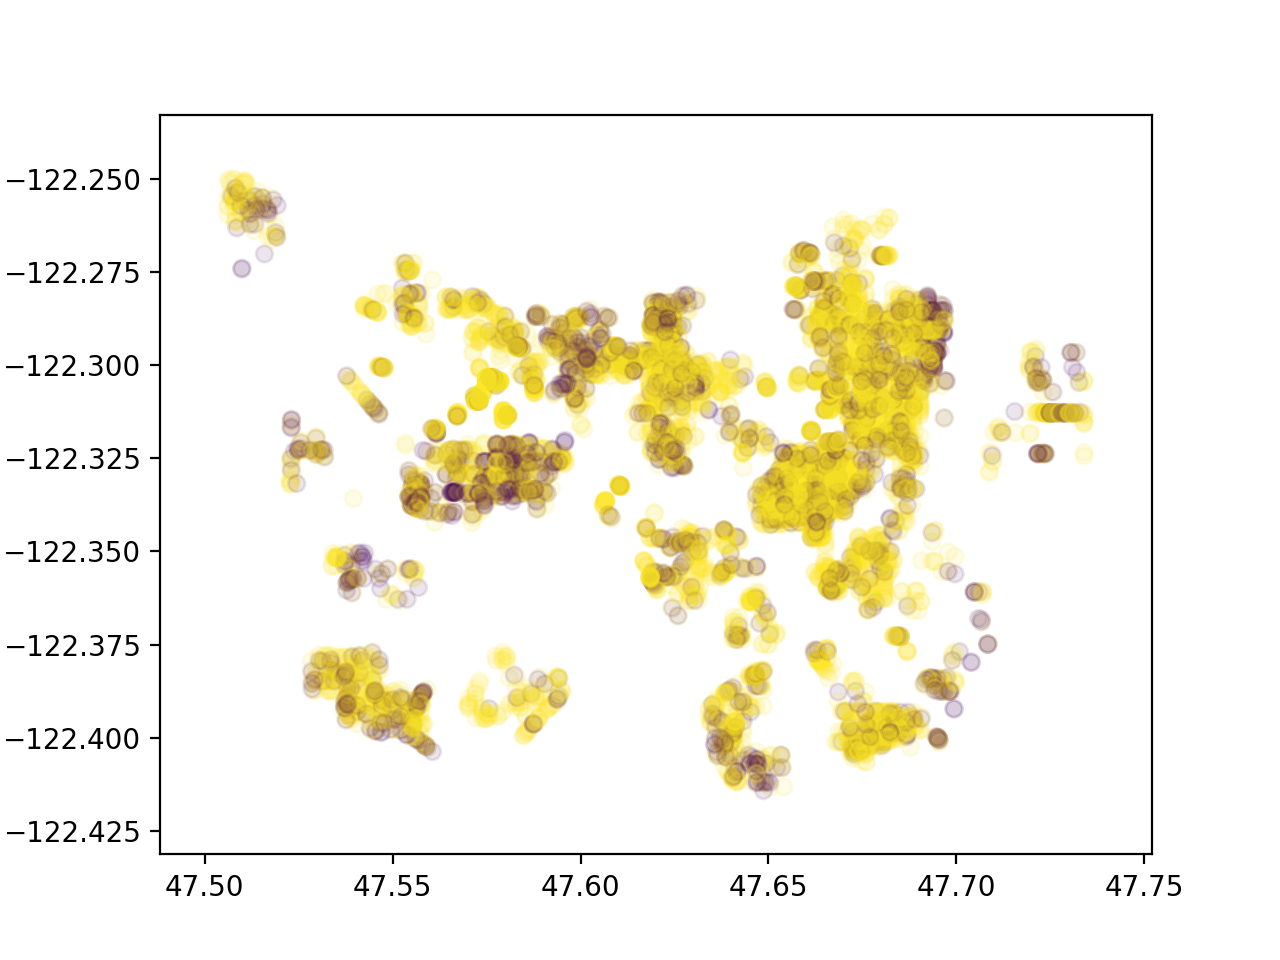

In [181]:
plt.figure()
plt.scatter(vals.lat, vals.lng, c=vals.correct, alpha=0.1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(vals[['lat', 'lng']], vals['correct'], test_size=0.2)

In [182]:
n_neighbors = 100

In [41]:
# neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
# neigh = RandomForestClassifier(n_estimators=1000)
neigh = BaggingClassifier(n_jobs=-1, n_estimators=1000)
# neigh = DecisionTreeClassifier()
neigh.fit(X_train, y_train)
prediction = neigh.predict_proba(X_test)
# prediction = neigh.predict(X_test)

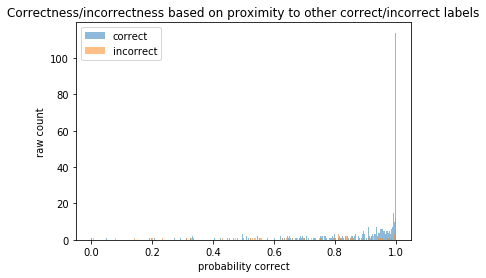

In [42]:
## plt.figure()
plt.title('Correctness/incorrectness based on proximity to other correct/incorrect labels')
plt.xlabel('probability correct')
plt.ylabel('raw count')
plt.hist(prediction[:, 1][y_test==1], bins=1000, alpha=0.5, label='correct')
plt.hist(prediction[:, 1][y_test==0], bins=1000, alpha=0.5, label='incorrect')
plt.legend()

In [43]:
mask = prediction[:, 1] == 1
print(np.sum(mask) / np.sum(y_test==1))
print(np.mean(y_test[mask]))

0.1156930126002291
0.900990099009901


In [44]:
X = vals[['lat', 'lng']].values
y = vals['correct'].values

In [102]:
from sklearn import neighbors
from sklearn.metrics import precision_score

In [99]:
# for radius in np.arange(0.000001, 0.000020, 0.000001):

radius = 0.000015
prec_sum = 0
recall_sum = 0
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    neigh = BaggingClassifier(n_jobs=-1, n_estimators=1000)
#     neigh = neighbors.RadiusNeighborsClassifier(radius=radius, outlier_label=-1)
    neigh.fit(X_train, y_train)
    prediction = neigh.predict_proba(X_test)
#     prediction = neigh.predict(X_test)
#     mask = prediction[:] == 1
    mask = prediction[:, 1] == 1
    prec_sum += np.mean(y_test[mask])
    recall_sum += np.sum(y_test[mask]) / np.sum(y_test==1)

#     print(f'radius: {radius:.6f}')
print(f'precision: {(100 * (prec_sum / 5)):.2f}%')
print(f'recall: {(100 * (recall_sum / 5)):.2f}%')


precision: 93.78%
recall: 8.76%


In [109]:
radius = 0.000017
prec_sum = 0
recall_sum = 0
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=0).split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
#     neigh = BaggingClassifier(n_jobs=-1, n_estimators=1000)
    neigh = neighbors.RadiusNeighborsClassifier(radius=radius, outlier_label=-1)
    neigh.fit(X_train, y_train)
#     prediction = neigh.predict_proba(X_test)
    prediction = neigh.predict(X_test)
    mask = prediction != -1
#     mask = prediction[:, 1] == 1
    prec_sum += precision_score(y_test[mask], prediction[mask])
#     recall_sum += np.sum(y_test[mask]) / np.sum(y_test==1)

#     print(f'radius: {radius:.6f}')
print(f'precision: {(100 * (prec_sum / 5)):.2f}%')
# print(f'recall: {(100 * (recall_sum / 5)):.2f}%')


precision: 93.44%


In [82]:
%matplotlib notebook

<IPython.core.display.Javascript object>


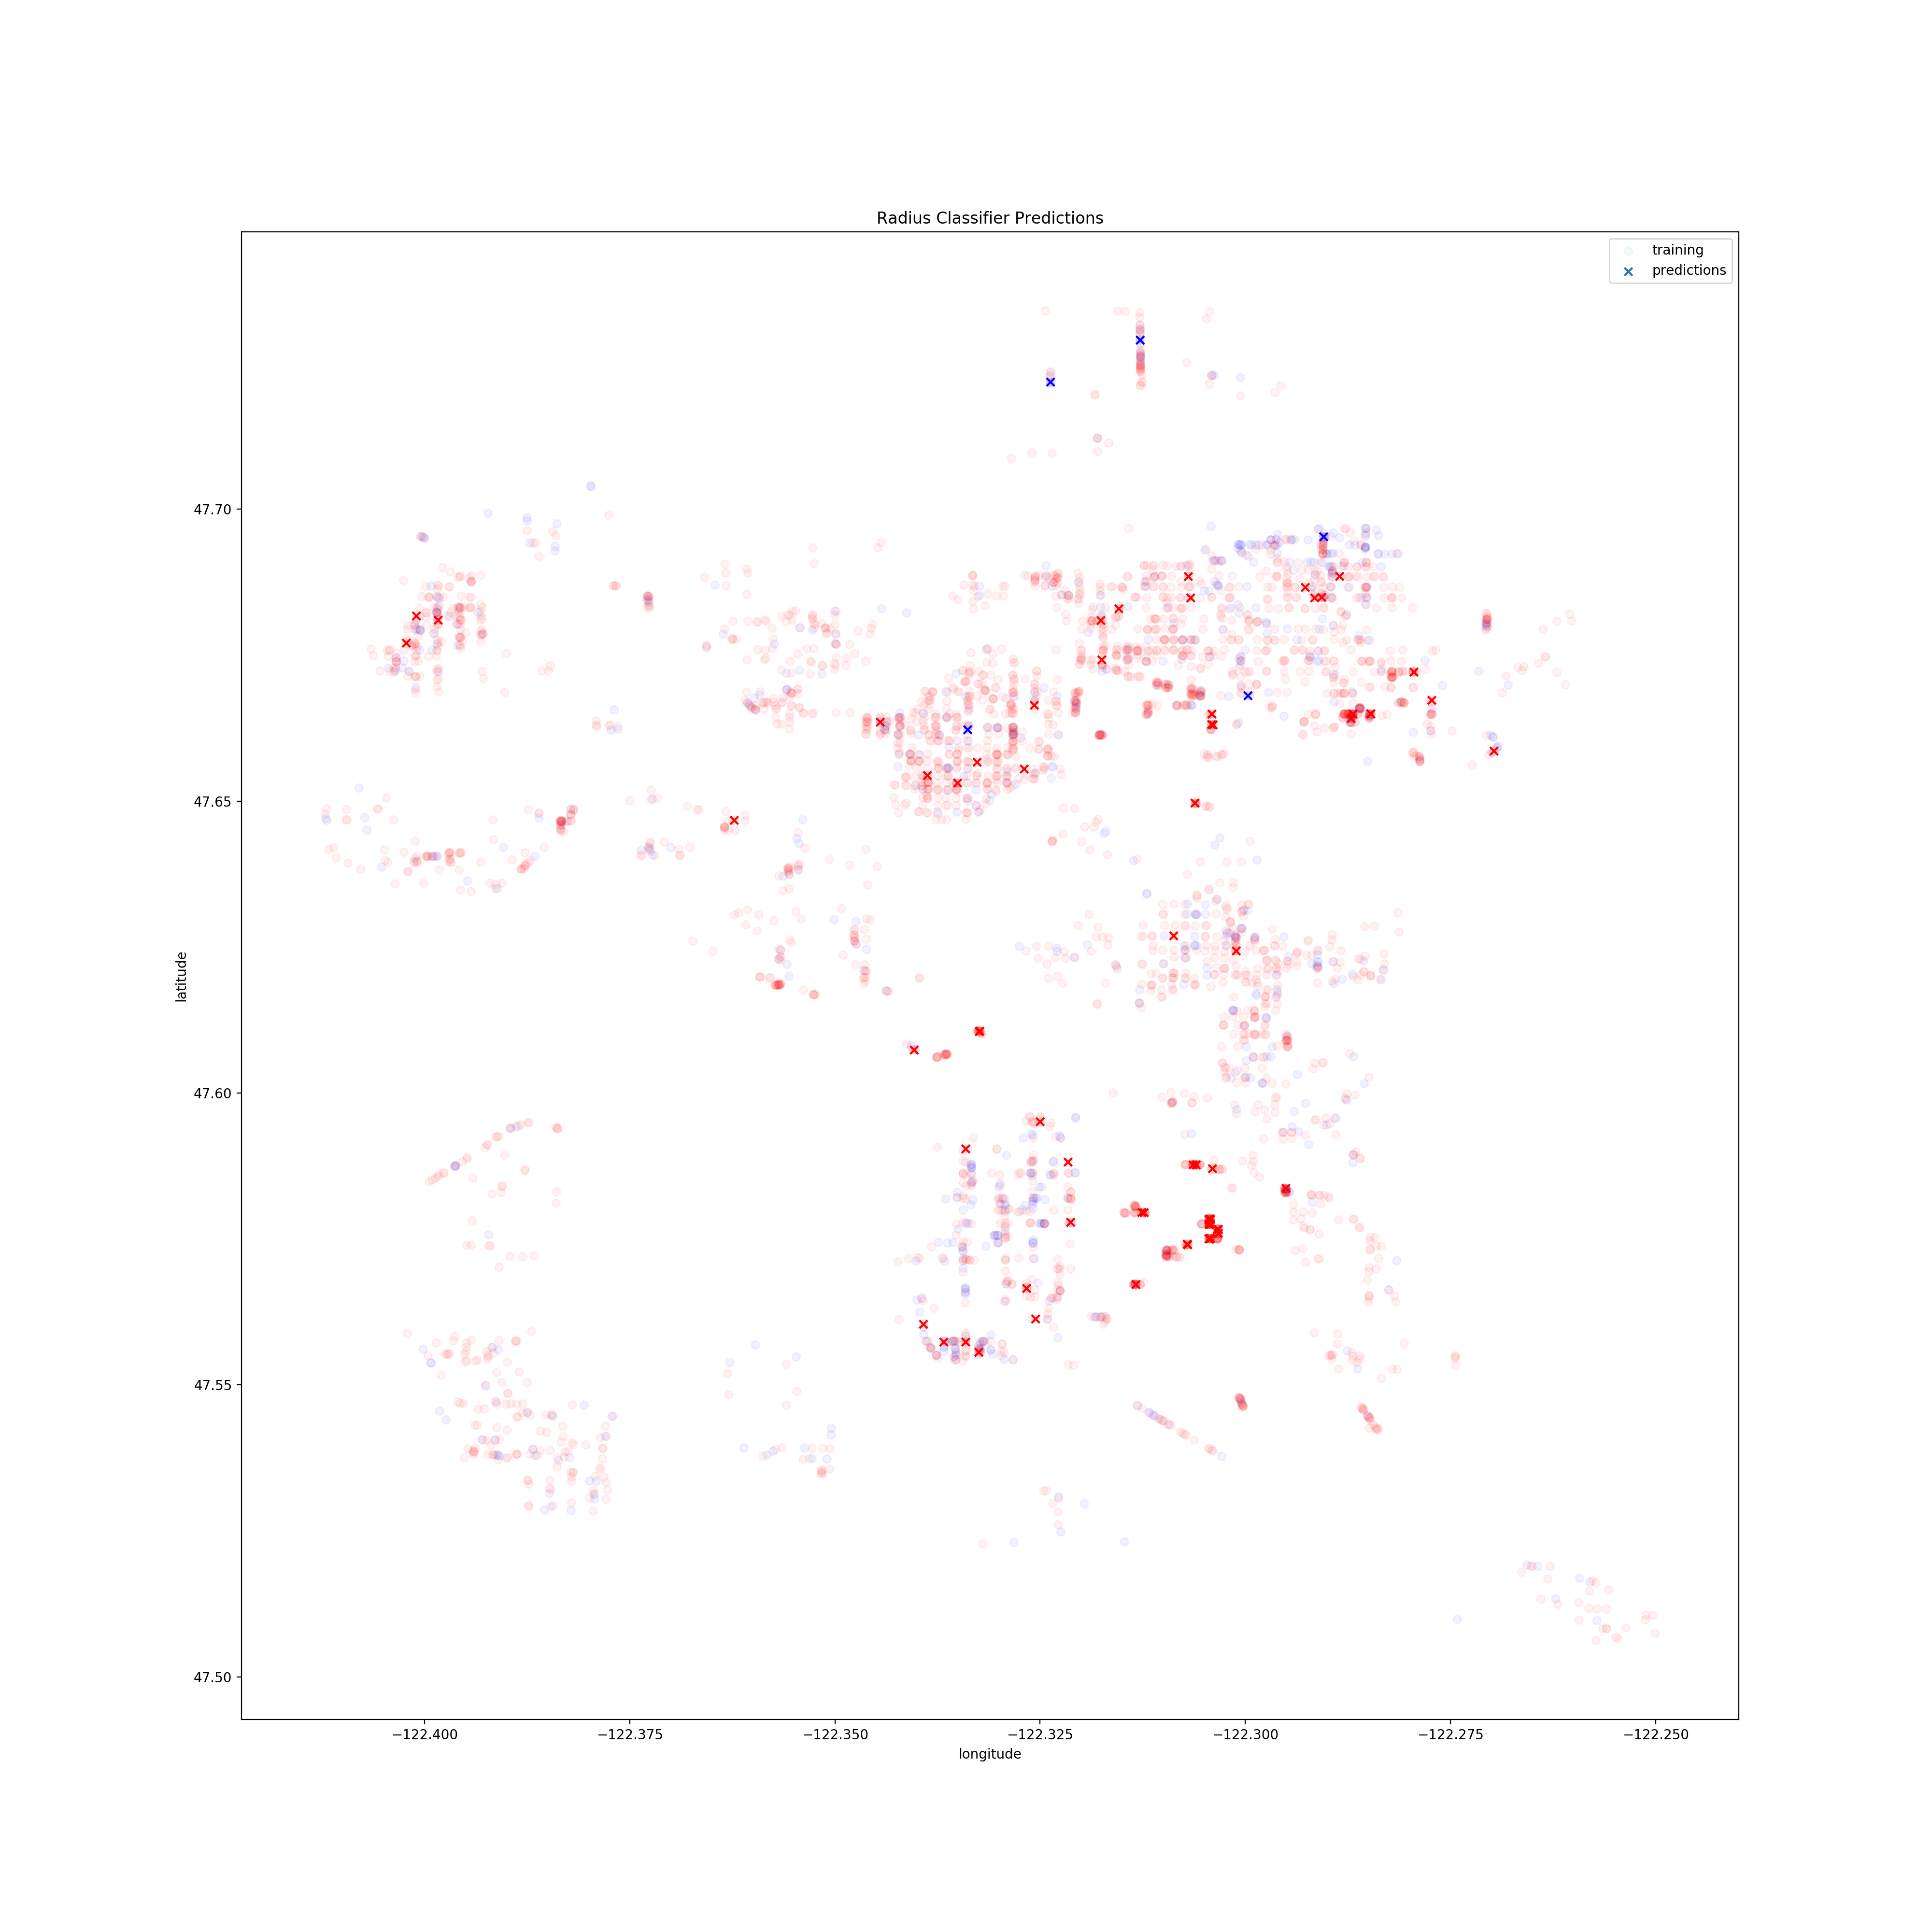

In [117]:
from matplotlib import colors
plt.figure(figsize=(20, 20))
plt.title('Radius Classifier Predictions')
plt.xlabel('longitude')
plt.ylabel('latitude')
cmap = colors.ListedColormap(['blue', 'red'])
plt.scatter(X_train[:, 1], X_train[:, 0], c=y_train, alpha=0.05, cmap=cmap, label='training')
plt.scatter(X_test[mask][:, 1], X_test[mask][:, 0], c=prediction[mask], marker='x', cmap=cmap, label='predictions')
plt.legend()
plt.savefig('radius_classifier_predictions.png')

# Classifying based on proximity to NoSidewalk Labels

In [183]:
from sklearn.neighbors import NearestNeighbors

In [194]:
neigh = NearestNeighbors(n_neighbors=4)

In [196]:
neigh.fit(no_sidewalk_labels)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=4, p=2, radius=1.0)

In [218]:
dist = neigh.kneighbors(vals[['lat', 'lng']])[0]
mean = np.mean(dist, axis=1)

<IPython.core.display.Javascript object>


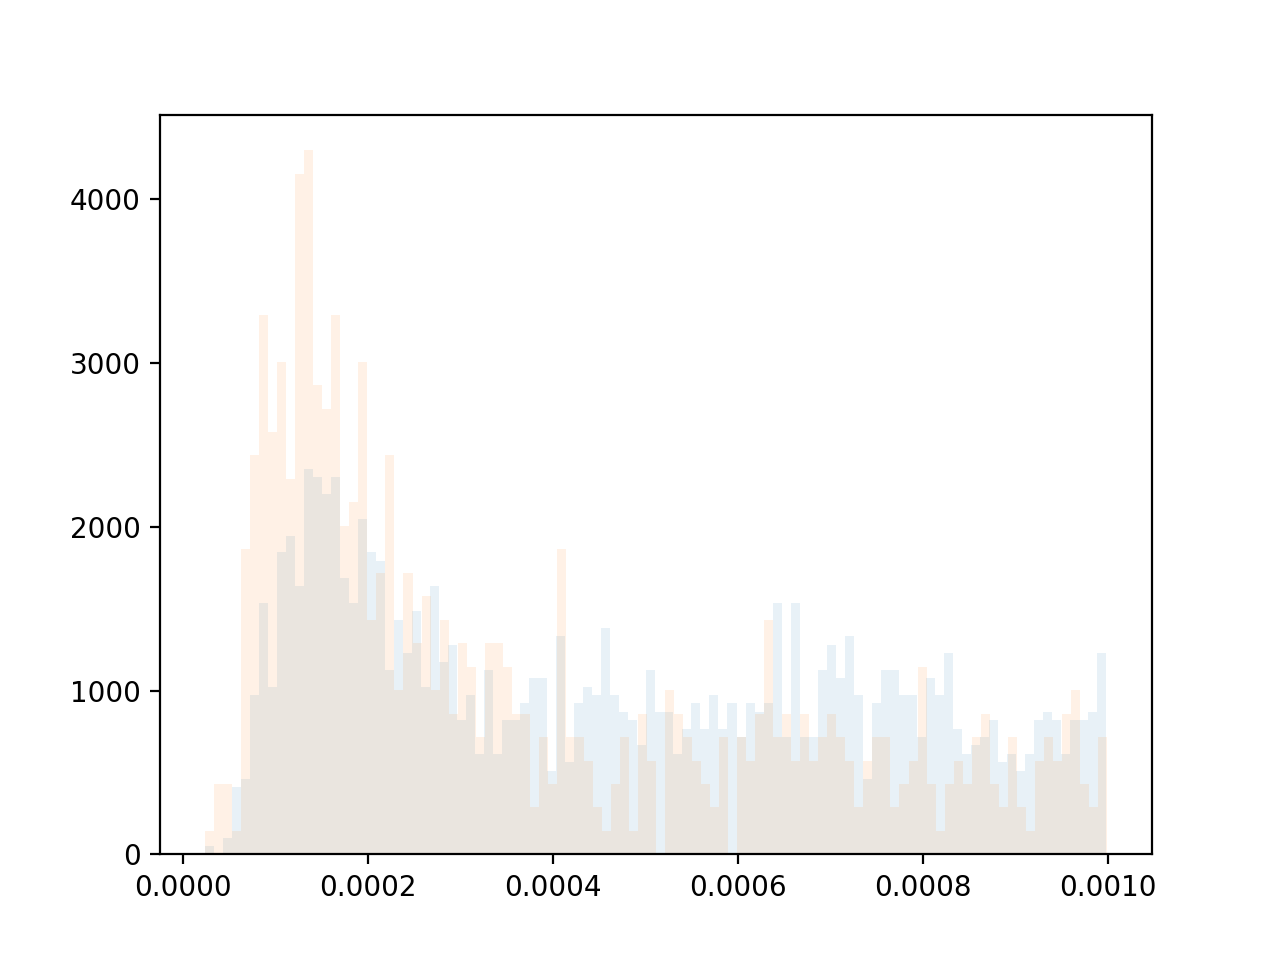

(array([ 143.29222783,  429.87668349,  429.87668349,  143.29222783,
        1862.79896179, 2435.96787311, 3295.72124009, 2579.26010094,
        3009.13678443, 2292.67564528, 4155.47460707, 4298.7668349 ,
        2865.8445566 , 2722.55232877, 3295.72124009, 2006.09118962,
        2149.38341745, 3009.13678443, 1432.9222783 , 1719.50673396,
        2435.96787311, 1003.04559481, 1719.50673396, 1289.63005047,
        1576.21450613, 1003.04559481, 1432.9222783 ,  859.75336698,
        1289.63005047, 1146.33782264,  716.46113915, 1289.63005047,
        1289.63005047, 1146.33782264,  859.75336698,  859.75336698,
         286.58445566,  716.46113915,  429.87668349, 1862.79896179,
         716.46113915,  716.46113915,  573.16891132,  286.58445566,
         143.29222783,  429.87668349,  716.46113915,  143.29222783,
         859.75336698,  573.16891132,    0.        , 1003.04559481,
         859.75336698,  716.46113915,  573.16891132,  429.87668349,
         286.58445566,  716.46113915,    0.     

In [221]:
plt.figure()
plt.hist(mean[(vals.correct == 1) & (mean < 0.001)], density=True, bins=100, alpha=0.1)
plt.hist(mean[(vals.correct == 0) & (mean < 0.001)], density=True, bins=100, alpha=0.1)

# Classification of common false positives

In [120]:
# These are in DC:
# fp_driveway = [80971, 79002, 78968, 78969, 78987, 78988, 79003, 80976, 80974, 80972, 78971, 78970, 78986, 33490, 35943, 15623, 11132, 7084, 17734, 5585, 13224, 15303, 116011, 112618, 113008, 85059, 113303, 94633, ]

# Proximity to NoSidewalk labels

In [124]:
labels.apply()

index  \
user_id                              audit_task_id temporary_label_id             
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51 3463          73                       480   
                                                   74                       717   
bf16418a-4c99-4fd6-99c6-7e8b40fbe17b 3458          159                     1192   
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51 3463          75                      1439   
                                                   76                      1589   
                                                   77                      1907   
                                     3468          78                      3916   
                                                   79                      4180   
                                                   80                      4727   
                                                   81                      5213   
                                                   83                      6318   
                                                   82                      6366   
                                                   84                      6990   
                                                   85                      7061   
                                     3471          86                      8991   
                                                   87                      9885   
                                                   88                     10067   
                                     3477          89                     12108   
                                                   90                     12686   
af812204-1521-4c42-bf88-4baaaffe3f06 3469          1                      13350   
                                                   2                      13728   
                                                   3                      13844   
                                                   4                      14119   
                                                   5                      14825   
                                                   6                      15599   
                                                   7                      15839   
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51 3480          91                     16598   
                                                   92                     17579   
af812204-1521-4c42-bf88-4baaaffe3f06 3469          9                      17693   
                                                   8                      18304   
...                                                                         ...   
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51 3453          51                  18487499   
bf16418a-4c99-4fd6-99c6-7e8b40fbe17b 3421          151                 18487608   
                                                   152                 18487771   
                                                   153                 18488239   
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51 3453          52                  18488797   
                                                   53                  18489222   
                                                   54                  18490221   
bf16418a-4c99-4fd6-99c6-7e8b40fbe17b 3421          154                 18490295   
                                                   155                 18490703   
2d9009b3-55d5-4aa8-a17a-a7c80afc4d51 3453          55                  18490919   
                                     3456          56                  18492009   
                                                   57                  18492630   
                                                   58                  18493020   
                                                   59                  18493770   
                                                   60                  18494451   
                                                   61                  18495157   
       